**Health Nutrition and Population Statistics Project**


We will be using the Health Nutrition and Population Statistics (HNPS) dataset that is provided by the World Bank. The dataset has over 300 health, nutrition, and population-related indicators for more than 200 countries and territories, spanning from 1960 to 2021. This dataset provides researchers the tools needed to understand and address health and nutrition issues across the globe - which include health outcomes, health system performance, communicable/non-communicable diseases, and nutrition - while also helping to assess the global and regional progress against broader United Nations (UN) goals. Use the cell below to load the HNPS dataset.

The world is currently facing a health, nutrition, and education crisis. While life expectancy is rising, there are higher rates of disease, obesity, and health issues, and lower rates of education among different nations and across the globe. This creates significant challenges for the healthcare system, economy, and quality of life. To address this, the UN has identified Sustainable Goals, which will focus on ending poverty, protecting the planet, and ensuring that by 2030 all people enjoy peace and prosperity.  Meeting these goals requires identifying changes/policies that the government and the world’s population need to make/have implemented to improve the overall health and wellness of the world. We plan to study the HNPS dataset, specifically forecasting how the world is trending towards achieving key Sustainable Goals based on responses and health outcomes/ diseases.  The ultimate objective of our project is to utilize the HNPS data set to identify if we are trending towards achieving a key Sustainable Goals, and why we are or are not trending towards the achievement of these goals. 

The UN Sustainable Goals that we will study include:

-No Poverty

# Section 0: Get Data
In this section we will download and prepare the data we will use for our project, including the following: 
- Import the required packages
- Downloading the data
- Reading the data

##Import Required Packages

In [1]:
from google.colab import drive

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Time series analysis
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim


## Downloading HNPS Data
This code mounts the Google Drive to the Colab runtime, creates a .kaggle directory, copies the Kaggle API token file from the mounted Google Drive to the .kaggle directory, downloads a dataset from Kaggle using the kaggle command line tool, and finally unzips the downloaded file.

In [2]:
drive.mount('/content/drive')

!mkdir -p ~/.kaggle

!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

!!kaggle datasets download -d sivamsinghsh/health-nutrition-and-population-statistics --force

!unzip -o /content/health-nutrition-and-population-statistics.zip

Mounted at /content/drive
Archive:  /content/health-nutrition-and-population-statistics.zip
  inflating: HNP_StatsEXCEL.xlsx     


## Downloading Country-to-Continent Data
This code copies the Kaggle API token file from the mounted Google Drive to the .kaggle directory, downloads a dataset from Kaggle using the kaggle command line tool, and finally unzips the downloaded file.

In [3]:
!!kaggle datasets download -d statchaitya/country-to-continent

!unzip -o /content/country-to-continent.zip

Archive:  /content/country-to-continent.zip
  inflating: countryContinent.csv    


## Reading Relevant HNPS Data

This code reads two specific tabs ('Data' and 'Country') from an Excel file called 'HNP_StatsEXCEL.xlsx' using the pandas library. The resulting data from the 'Data' tab is assigned to a dataframe called hnp_df and the resulting data from the 'Country' tab is assigned to a dataframe called hnp_country_info_df.

In [4]:
tabs_to_read = ['Data', 'Country']

dfs = pd.read_excel('HNP_StatsEXCEL.xlsx', sheet_name=tabs_to_read)

hnp_df = dfs['Data']
hnp_country_info_df = dfs['Country']

In [5]:
print("Shape of hnp_df:", hnp_df.shape)
print("Shape of hnp_country_info_df:", hnp_country_info_df.shape)

Shape of hnp_df: (117838, 66)
Shape of hnp_country_info_df: (265, 30)


## Reading Relevant Country-to-Continent Data

This code reads in data from a CSV file called 'countryContinent.csv' using the pandas library. The data is assigned to a dataframe called continents_df.

In [6]:
import chardet

with open('countryContinent.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

continent_df = pd.read_csv('countryContinent.csv', encoding='ISO-8859-1')

In [7]:
print("Shape of continent_df:", continent_df.shape)

Shape of continent_df: (249, 9)


# Section 1: Preprocesing & EDA
In this section, we will prepare our data for modeling. Additionally, we start to generate some descriptive statistics to generate hypotheses for modeling. 

## `hnp_df`

Let's start by looking at the first few rows of `hnp_df`, which we loaded in the previous section. 

In [8]:
hnp_df.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Africa Eastern and Southern,AFE,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,141.457567,141.603817,141.796749,141.651778,141.595374,141.593273,...,105.321998,103.629032,101.905042,100.133826,98.367869,96.574004,95.011793,93.43222,91.845198,NaN
1,Africa Eastern and Southern,AFE,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Africa Eastern and Southern,AFE,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tranposing the Data

We notice that in it's raw format, year's are displayed as columns and indicators are displayed as rows. 

We want to transpose `hnp_df`  so that the year columns (i.e., 1960 - 2021) become a row titled as 'year', and the Indicator Name rows are transformed into columns.  This is a more favorable structure for modeling and analysis. 

In [9]:
# Melt the dataframe to unpivot the 'Indicator Name' column
melted_df = hnp_df.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name'], var_name='Year', value_name='Value')

# Replace empty strings and 'missing_value' with NaN
melted_df.replace(['', 'missing_value'], np.nan, inplace=True)

# Pivot the melted dataframe to reshape it
hnp_df_transpose = melted_df.pivot(index=['Country Name', 'Country Code', 'Year'], columns='Indicator Name', values='Value').reset_index().rename_axis(None, axis=1)

# Drop rows where 'Year' is 'Indicator Code'
hnp_df_transpose = hnp_df_transpose[hnp_df_transpose['Year'] != 'Indicator Code']


In [10]:
hnp_df_transpose.head(3)

,Country Name,Country Code,Year,AIDS estimated deaths (UNAIDS estimates),ARI treatment (% of children under 5 taken to a health provider),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Adults (ages 15+) and children (0-14 years) living with HIV,Adults (ages 15+) and children (ages 0-14) newly infected with HIV,Adults (ages 15+) living with HIV,Adults (ages 15-49) newly infected with HIV,...,Urban population (% of total population),Urban population growth (annual %),Urban poverty headcount ratio at national poverty lines (% of urban population),Use of insecticide-treated bed nets (% of under-5 population),Vitamin A supplementation coverage rate (% of children ages 6-59 months),Wanted fertility rate (births per woman),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
0,Afghanistan,AFG,1960,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,8.401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1961,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,8.684,5.239185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1962,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,8.976,5.322099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Column Types 

We need to ensure all numeric columns have a numeric datatype. This is preferred for modeling and analysis. 

In [11]:
# Get a list of columns that have non-numeric data
non_numeric_cols = [x for x in hnp_df_transpose.select_dtypes(exclude=[np.number]).columns.tolist() if x not in ['Country Name','Country Code']]

# Convert only the non-numeric columns to numeric
hnp_df_transpose[non_numeric_cols] = hnp_df_transpose[non_numeric_cols].apply(pd.to_numeric, errors='coerce', downcast='integer')

In [12]:
hnp_df_transpose.head(3)

,Country Name,Country Code,Year,AIDS estimated deaths (UNAIDS estimates),ARI treatment (% of children under 5 taken to a health provider),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Adults (ages 15+) and children (0-14 years) living with HIV,Adults (ages 15+) and children (ages 0-14) newly infected with HIV,Adults (ages 15+) living with HIV,Adults (ages 15-49) newly infected with HIV,...,Urban population (% of total population),Urban population growth (annual %),Urban poverty headcount ratio at national poverty lines (% of urban population),Use of insecticide-treated bed nets (% of under-5 population),Vitamin A supplementation coverage rate (% of children ages 6-59 months),Wanted fertility rate (births per woman),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
0,Afghanistan,AFG,1960,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,8.401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1961,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,8.684,5.239185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1962,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,8.976,5.322099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Convert all of the Indicator Name columns to float type instead of object type.

In [13]:
# Apears that we may no longer need this?

#last_444_columns = hnp_df_transpose.iloc[:, -444:]

# Convert the last 444 columns to float
#converted_columns = last_444_columns.apply(pd.to_numeric, errors='coerce')

# Replace the original columns with the converted ones
#hnp_df_transpose.iloc[:, -444:] = converted_columns

Review some high level statistics of the data by using .info() and .describe() on the dataset.

In [14]:
hnp_df_transpose.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16492 entries, 0 to 16756
Columns: 446 entries, Country Name to Young people (ages 15-24) newly infected with HIV
dtypes: float64(443), int16(1), object(2)
memory usage: 56.1+ MB


In [15]:
hnp_df_transpose.describe()

,Year,AIDS estimated deaths (UNAIDS estimates),ARI treatment (% of children under 5 taken to a health provider),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Adults (ages 15+) and children (0-14 years) living with HIV,Adults (ages 15+) and children (ages 0-14) newly infected with HIV,Adults (ages 15+) living with HIV,Adults (ages 15-49) newly infected with HIV,"Age at first marriage, female","Age at first marriage, male",...,Urban population (% of total population),Urban population growth (annual %),Urban poverty headcount ratio at national poverty lines (% of urban population),Use of insecticide-treated bed nets (% of under-5 population),Vitamin A supplementation coverage rate (% of children ages 6-59 months),Wanted fertility rate (births per woman),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
count,16492.000000,4.402000e+03,439.000000,14518.000000,4.469000e+03,4.242000e+03,4.438000e+03,4.178000e+03,2073.000000,1848.000000,...,16058.000000,15769.000000,0.0,304.000000,1360.000000,339.000000,438.000000,528.000000,6109.000000,4178.000000
mean,1990.500000,1.695810e+04,57.522498,75.615332,3.495743e+05,3.351393e+04,3.225617e+05,2.513162e+04,24.440376,28.165747,...,50.383041,2.893988,NaN,32.080914,58.741640,3.464919,7.621699,27.982436,39.190369,10166.562949
std,17.896073,1.139450e+05,18.633517,52.492367,2.431295e+06,2.152288e+05,2.270563e+06,1.700906e+05,3.823171,3.109531,...,24.793641,2.870765,NaN,23.684325,32.439551,1.355027,7.978835,16.885166,16.315843,67692.215399
min,1960.000000,1.000000e+02,12.000000,0.283000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,14.400000,20.800000,...,2.077000,-189.743417,NaN,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,100.000000
25%,1975.000000,1.000000e+02,43.850000,31.539502,2.100000e+03,5.000000e+02,2.000000e+03,2.000000e+02,21.700000,25.800000,...,30.186250,1.221706,NaN,7.850000,33.954563,2.250000,2.100000,15.300000,26.100000,100.000000
50%,1990.500000,5.300000e+02,59.000000,64.970200,1.500000e+04,1.500000e+03,1.400000e+04,1.200000e+03,23.600000,27.600000,...,49.096401,2.695207,NaN,33.650000,65.511294,3.400000,5.500000,25.720220,39.500000,500.000000
75%,2006.000000,4.200000e+03,71.100000,110.954375,9.700000e+04,8.700000e+03,8.600000e+04,6.200000e+03,27.000000,30.300000,...,69.709750,4.189606,NaN,51.750000,88.000000,4.500000,10.075000,38.175000,54.411987,2300.000000
max,2021.000000,2.000000e+06,97.500000,232.483800,3.840000e+07,3.200000e+06,3.670000e+07,2.500000e+06,34.100000,36.900000,...,100.000000,52.476419,NaN,95.500000,99.000000,7.400000,50.300000,83.500000,89.700000,1000000.000000


## `Merge columns from hnp_country_info_df with hnp_df_transpose`


**HNPS Country Tab**

Join key columns ('Country Code','Currency Unit', 'Region','Income Group','Government Accounting concept') from our hnp_country_info_df dataframe.

In [16]:
hnp_country_info_df = hnp_country_info_df[['Country Code','Currency Unit', 'Region','Income Group','Government Accounting concept']]
hnp_df_transpose = hnp_df_transpose.merge(hnp_country_info_df, on='Country Code', how='left')
hnp_df_transpose.head(3)

,Country Name,Country Code,Year,AIDS estimated deaths (UNAIDS estimates),ARI treatment (% of children under 5 taken to a health provider),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Adults (ages 15+) and children (0-14 years) living with HIV,Adults (ages 15+) and children (ages 0-14) newly infected with HIV,Adults (ages 15+) living with HIV,Adults (ages 15-49) newly infected with HIV,...,Vitamin A supplementation coverage rate (% of children ages 6-59 months),Wanted fertility rate (births per woman),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV,Currency Unit,Region,Income Group,Government Accounting concept
0,Afghanistan,AFG,1960,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Afghan afghani,South Asia,Low income,Consolidated central government
1,Afghanistan,AFG,1961,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Afghan afghani,South Asia,Low income,Consolidated central government
2,Afghanistan,AFG,1962,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Afghan afghani,South Asia,Low income,Consolidated central government


## `Merge columns from continents_df with hnp_df_transpose`

**Continent df**

Join key columns ('continent', 'sub_region') from our continent df dataframe.

In [17]:
continent_info_df = continent_df[['code_3','continent', 'sub_region']]
continent_info_df.rename(columns = {'code_3':'Country Code'}, inplace = True)
hnp_df_transpose = hnp_df_transpose.merge(continent_info_df, on='Country Code', how='left')
hnp_df_transpose.head(3)

<ipython-input-17-65e594b21002>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continent_info_df.rename(columns = {'code_3':'Country Code'}, inplace = True)


,Country Name,Country Code,Year,AIDS estimated deaths (UNAIDS estimates),ARI treatment (% of children under 5 taken to a health provider),"Adolescent fertility rate (births per 1,000 women ages 15-19)",Adults (ages 15+) and children (0-14 years) living with HIV,Adults (ages 15+) and children (ages 0-14) newly infected with HIV,Adults (ages 15+) living with HIV,Adults (ages 15-49) newly infected with HIV,...,Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV,Currency Unit,Region,Income Group,Government Accounting concept,continent,sub_region
0,Afghanistan,AFG,1960,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Afghan afghani,South Asia,Low income,Consolidated central government,Asia,Southern Asia
1,Afghanistan,AFG,1961,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Afghan afghani,South Asia,Low income,Consolidated central government,Asia,Southern Asia
2,Afghanistan,AFG,1962,NaN,NaN,145.245,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Afghan afghani,South Asia,Low income,Consolidated central government,Asia,Southern Asia


In [18]:
print(hnp_df_transpose.shape)

(16492, 452)


**No Poverty**: 

One of the UN Sustainable Goals in 2015 was by 2030 to reduce at least by half the proportion of men, women and children of all ages living in poverty in all its dimensions according to national definitions.  Since we are in 2023 and only have data to 2021, we are almost halfway through the timeframe set by the UN.  With half of the timeframe done, we will forecast how the world is trending towards the goal, and what the UN can do to either change it's trajectory or continue it's strong trajectory.

The HNPS dataset is large and covers a lot of information. Since we want to forecast/predict the poverty levels, we will remove all columns/ Indicator Names that are not Poverty related.  Remove all columns that are not poverty related, and the columns that have all null values.

In [19]:
selected_columns = [
'Year',
'Country Name',
'Country Code',
'Region',
'sub_region',
'continent',
'Income Group',
'Government Accounting concept',
'Capital health expenditure (% of GDP)',
'Labor force, female (% of total labor force)',
'Labor force, total',
'Number of people pushed below the $1.90 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure',
'Number of people pushed below the $3.20 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure',
'Number of people pushed below the 60% median consumption poverty line by out-of-pocket health care expenditure',
'Number of people pushed further below the $1.90 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure',
'Number of people pushed further below the $3.20 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure',
'Number of people pushed further below the 60% median consumption poverty line by out-of-pocket health care expenditure',
'Number of people spending more than 10% of household consumption or income on out-of-pocket health care expenditure',
'Number of people spending more than 25% of household consumption or income on out-of-pocket health care expenditure',
'Number of people who are undernourished',
'People using at least basic drinking water services (% of population)',
'People using at least basic drinking water services, rural (% of rural population)',
'People using at least basic drinking water services, urban (% of urban population)',
'People using at least basic sanitation services (% of population)',
'People using at least basic sanitation services, rural (% of rural population)',
'People using at least basic sanitation services, urban  (% of urban population)',
'Population ages 00-04, female',
'Population ages 00-04, female (% of female population)',
'Population ages 00-04, male',
'Population ages 00-04, male (% of male population)',
'Population ages 00-14, total',
'Population ages 0-14 (% of total population)',
'Population ages 0-14, female',
'Population ages 0-14, female (% of female population)',
'Population ages 0-14, male',
'Population ages 0-14, male (% of male population)',
'Population ages 05-09, female',
'Population ages 05-09, female (% of female population)',
'Population ages 05-09, male',
'Population ages 05-09, male (% of male population)',
'Population ages 10-14, female',
'Population ages 10-14, female (% of female population)',
'Population ages 10-14, male',
'Population ages 10-14, male (% of male population)',
'Population ages 15-19, female',
'Population ages 15-19, female (% of female population)',
'Population ages 15-19, male',
'Population ages 15-19, male (% of male population)',
'Population ages 15-64 (% of total population)',
'Population ages 15-64, female',
'Population ages 15-64, female (% of female population)',
'Population ages 15-64, male',
'Population ages 15-64, male (% of male population)',
'Population ages 15-64, total',
'Population ages 20-24, female',
'Population ages 20-24, female (% of female population)',
'Population ages 20-24, male',
'Population ages 20-24, male (% of male population)',
'Population ages 25-29, female',
'Population ages 25-29, female (% of female population)',
'Population ages 25-29, male',
'Population ages 25-29, male (% of male population)',
'Population ages 30-34, female',
'Population ages 30-34, female (% of female population)',
'Population ages 30-34, male',
'Population ages 30-34, male (% of male population)',
'Population ages 35-39, female',
'Population ages 35-39, female (% of female population)',
'Population ages 35-39, male',
'Population ages 35-39, male (% of male population)',
'Population ages 40-44, female',
'Population ages 40-44, female (% of female population)',
'Population ages 40-44, male',
'Population ages 40-44, male (% of male population)',
'Population ages 45-49, female',
'Population ages 45-49, female (% of female population)',
'Population ages 45-49, male',
'Population ages 45-49, male (% of male population)',
'Population ages 50-54, female',
'Population ages 50-54, female (% of female population)',
'Population ages 50-54, male',
'Population ages 50-54, male (% of male population)',
'Population ages 55-59, female',
'Population ages 55-59, female (% of female population)',
'Population ages 55-59, male',
'Population ages 55-59, male (% of male population)',
'Population ages 60-64, female',
'Population ages 60-64, female (% of female population)',
'Population ages 60-64, male',
'Population ages 60-64, male (% of male population)',
'Population ages 65 and above (% of total population)',
'Population ages 65 and above, female',
'Population ages 65 and above, female (% of female population)',
'Population ages 65 and above, male',
'Population ages 65 and above, male (% of male population)',
'Population ages 65 and above, total',
'Population ages 65-69, female',
'Population ages 65-69, female (% of female population)',
'Population ages 65-69, male',
'Population ages 65-69, male (% of male population)',
'Population ages 70-74, female',
'Population ages 70-74, female (% of female population)',
'Population ages 70-74, male',
'Population ages 70-74, male (% of male population)',
'Population ages 75-79, female',
'Population ages 75-79, female (% of female population)',
'Population ages 75-79, male',
'Population ages 75-79, male (% of male population)',
'Population ages 80 and above, female',
'Population ages 80 and above, male',
'Population ages 80 and above, male (% of male population)',
'Population ages 80 and older, female (% of female population)',
'Population growth (annual %)', 'Population, female',
'Population, female (% of total population)',
'Population, male',
'Population, male (% of total population)',
'Population, total',
'Poverty headcount ratio at national poverty line (% of population)',
'Prevalence of undernourishment (% of population)',
'Prevalence of underweight, weight for age (% of children under 5)',
'Prevalence of underweight, weight for age, female (% of children under 5)',
'Prevalence of underweight, weight for age, male (% of children under 5)',
'Proportion of population pushed below the $1.90 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure (%)',
'Proportion of population pushed below the $3.20 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure (%)',
'Proportion of population pushed below the 60% median consumption poverty line by out-of-pocket health expenditure (%)',
'Proportion of population pushed further below the $1.90 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure (%)',
'Proportion of population pushed further below the $3.20 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure (%)',
'Proportion of population pushed further below the 60% median consumption poverty line by out-of-pocket health care expenditure (%)',
'Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%)',
'Proportion of population spending more than 25% of household consumption or income on out-of-pocket health care expenditure (%)',
'Risk of impoverishing expenditure for surgical care (% of people at risk)',
'Rural population',
'Rural population (% of total population)',
'Rural population growth (annual %)',
'Rural poverty headcount ratio at national poverty lines (% of rural population)',
'School enrollment, primary (% gross)',
'School enrollment, primary (% net)',
'School enrollment, primary, female (% gross)',
'School enrollment, primary, female (% net)',
'School enrollment, primary, male (% gross)',
'School enrollment, primary, male (% net)',
'School enrollment, secondary (% gross)',
'School enrollment, secondary (% net)',
'School enrollment, secondary, female (% gross)',
'School enrollment, secondary, female (% net)',
'School enrollment, secondary, male (% gross)',
'School enrollment, secondary, male (% net)',
'School enrollment, tertiary (% gross)',
'School enrollment, tertiary, female (% gross)',
'Unemployment, female (% of female labor force)',
'Unemployment, male (% of male labor force)',
'Unemployment, total (% of total labor force)',
'Urban population',
'Urban population (% of total population)',
'Urban population growth (annual %)',
'Urban poverty headcount ratio at national poverty lines (% of urban population)']

In [20]:
#Removing columns with all null values
hnp_df_selected = hnp_df_transpose[selected_columns]
hnp_df_selected = hnp_df_selected.loc[:, ~hnp_df_selected.isnull().all()]
print(hnp_df_selected.dtypes)

Year                                              int16
Country Name                                     object
Country Code                                     object
Region                                           object
sub_region                                       object
                                                 ...   
Unemployment, male (% of male labor force)      float64
Unemployment, total (% of total labor force)    float64
Urban population                                float64
Urban population (% of total population)        float64
Urban population growth (annual %)              float64
Length: 155, dtype: object


**Calculating the Poverty, Total**

Since HNPS does not have a similar question/ Indicator Name that tells us the total number of people in poverty for each year, and each country, we will create this column/value.  In order to create this value, we multiply the 'Poverty headcount ratio at national poverty line (% of population)' * 'Population, total'. 'Poverty headcount ratio at national poverty line (% of population)' is the % of the countries population that is below the national poverty line. Before creating this column, we will see if these two columns have adequate data/ is complete.

In [21]:
# calculate the percentage of non-null values in each field
pop_completion = hnp_df_selected['Population, total'].notnull().sum() / len(hnp_df_selected) * 100
poverty_completion = hnp_df_selected['Poverty headcount ratio at national poverty line (% of population)'].notnull().sum() / len(hnp_df_selected) * 100

# print the results
print(f"Population completion: {pop_completion:.2f}%")
print(f"Poverty completion: {poverty_completion:.2f}%")

Population completion: 97.94%
Poverty completion: 6.54%


**Impute Values Using KNN**

As you can see, we have adequate information for the population; however, only 6.55% of our data has the 'Poverty headcount ratio at national poverty line (% of population)' complete. Because of this, we will use modeling to predict what the value of the 'Poverty headcount ratio at national poverty line (% of population)' should be for each year - country combination.  In order to do this, we will need to impute any missing values for data in the 6.55% of our transactions and then use several modeling techniques to determine what model we can use to predict the 'Poverty headcount ratio at national poverty line (% of population)' value for the other ~93% of year - country combinations.  We will select the best model based on the R-squared score and apply that model to the rest of our data (i.e., ~93%).


As noted above, impute the NaN values for the rows in our dataset that have the 'Poverty headcount ratio at national poverty line (% of population)' complete. 

In [22]:
#from sklearn.impute import KNNImputer
poverty_completion_only = hnp_df_selected[hnp_df_selected['Poverty headcount ratio at national poverty line (% of population)']>0]

columns_to_encode = ['Country Name',  'Region', 'Income Group', 'Government Accounting concept']
poverty_completion_only_one_hot = pd.get_dummies(poverty_completion_only, columns=columns_to_encode)

poverty_completion_only_one_hot = poverty_completion_only_one_hot.iloc[:,4:]
poverty_completion_only_one_hot = poverty_completion_only_one_hot.dropna(axis=1, how='all')

knn_imputer = KNNImputer(n_neighbors=5)
knn_imputed_data = knn_imputer.fit_transform(poverty_completion_only_one_hot)
poverty_completion_only_knn = pd.DataFrame(knn_imputed_data, columns=poverty_completion_only_one_hot.columns, index=poverty_completion_only_one_hot.index)

In [23]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

Set the 'Poverty headcount ratio at national poverty line (% of population)' as the target/ y value.  Split the data into training and testing datasets.

In [24]:
X = poverty_completion_only_knn.drop('Poverty headcount ratio at national poverty line (% of population)', axis=1)
y = poverty_completion_only_knn['Poverty headcount ratio at national poverty line (% of population)']
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.columns = X.columns
X_test.columns = X.columns

Train and test the Decision Tree model.

In [25]:
# Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)
print("\nDecision Tree:")
print("Decision Tree MSE:", dt_mse)
print("Decision Tree R2:", dt_r2)


Decision Tree:
Decision Tree MSE: 102.79376543209874
Decision Tree R2: 0.6410355149398363


Train and test the Linear Regression model.

In [26]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
print("\nLinear Regression:")
print("Linear Regression MSE:", lr_mse)
print("Linear Regression R2:", lr_r2)


Linear Regression:
Linear Regression MSE: 199.79243451210417
Linear Regression R2: 0.30230799434107614


Train and test the Lasso Regression model.

In [27]:
#Lasso Regression
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)
print("\nLasso Regression:")
print(f"Mean Squared Error: {lasso_mse}")
print(f"R^2 Score: {lasso_r2}")


Lasso Regression:
Mean Squared Error: 104.45642451445482
R^2 Score: 0.6352293694132112


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.998e+04, tolerance: 1.697e+01
  model = cd_fast.enet_coordinate_descent(


Train and test the Ridge Regression model.

In [28]:
# Ridge Regression
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)
ridge_train_x = X_train
print("\nRidge Regression:")
print(f"Mean Squared Error: {ridge_mse}")
print(f"R^2 Score: {ridge_r2}")


Ridge Regression:
Mean Squared Error: 68.3329636747337
R^2 Score: 0.7613755365899253


Train and test the Elastic Net Regression model.

In [29]:
# Elastic Net Regression
elastic_net_model = ElasticNet()
elastic_net_model.fit(X_train, y_train)
elastic_net_predictions = elastic_net_model.predict(X_test)
elastic_net_mse = mean_squared_error(y_test, elastic_net_predictions)
elastic_net_r2 = r2_score(y_test, elastic_net_predictions)
print("\nElastic Net Regression:")
print(f"Mean Squared Error: {elastic_net_mse}")
print(f"R^2 Score: {elastic_net_r2}")


Elastic Net Regression:
Mean Squared Error: 101.58791546529994
R^2 Score: 0.6452464445674477


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.887e+04, tolerance: 1.697e+01
  model = cd_fast.enet_coordinate_descent(


Train and test the SVM model.

In [30]:
# Support Vector Machine (SVM)
svm_model = SVR()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_r2 = r2_score(y_test, svm_predictions)
print("\nSVM:")
print("SVM MSE:", svm_mse)
print("SVM R2:", svm_r2)


SVM:
SVM MSE: 301.56459133285495
SVM R2: -0.053088947419510646


Train and test a Feedforward Neural Network model.

In [31]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train.values).view(-1, 1)
y_test = torch.FloatTensor(y_test.values).view(-1, 1)

# Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

nn_model = NeuralNetwork(X_train.shape[1])

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters())

# Train the model
epochs = 100
for epoch in range(epochs):
    # Forward pass
    outputs = nn_model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Make predictions
nn_model.eval()
with torch.no_grad():
    nn_predictions = nn_model(X_test).numpy()

# Calculate accuracy
nn_mse = mean_squared_error(y_test, nn_predictions)
nn_r2 = r2_score(y_test, nn_predictions)

# Print accuracy
print("\nNeural Network (PyTorch):")
print(f"Mean Squared Error: {nn_mse}")
print(f"R^2 Score: {nn_r2}")


Neural Network (PyTorch):
Mean Squared Error: 298.46527099609375
R^2 Score: -0.042265844165522815


**Models Accuracy Summary:**

Below is the MSE and R-squared of all models that we defined.

In [32]:
print("\nDecision Tree:")
print("Decision Tree MSE:", dt_mse)
print("Decision Tree R2:", dt_r2)

print("\nLinear Regression:")
print("Linear Regression MSE:", lr_mse)
print("Linear Regression R2:", lr_r2)

print("\nLasso Regression:")
print(f"Mean Squared Error: {lasso_mse}")
print(f"R^2 Score: {lasso_r2}")

print("\nRidge Regression:")
print(f"Mean Squared Error: {ridge_mse}")
print(f"R^2 Score: {ridge_r2}")

print("\nElastic Net Regression:")
print(f"Mean Squared Error: {elastic_net_mse}")
print(f"R^2 Score: {elastic_net_r2}")

print("\nSVM:")
print("SVM MSE:", svm_mse)
print("SVM R2:", svm_r2)

print("\nNeural Network (PyTorch):")
print(f"Mean Squared Error: {nn_mse}")
print(f"R^2 Score: {nn_r2}")


Decision Tree:
Decision Tree MSE: 102.79376543209874
Decision Tree R2: 0.6410355149398363

Linear Regression:
Linear Regression MSE: 199.79243451210417
Linear Regression R2: 0.30230799434107614

Lasso Regression:
Mean Squared Error: 104.45642451445482
R^2 Score: 0.6352293694132112

Ridge Regression:
Mean Squared Error: 68.3329636747337
R^2 Score: 0.7613755365899253

Elastic Net Regression:
Mean Squared Error: 101.58791546529994
R^2 Score: 0.6452464445674477

SVM:
SVM MSE: 301.56459133285495
SVM R2: -0.053088947419510646

Neural Network (PyTorch):
Mean Squared Error: 298.46527099609375
R^2 Score: -0.042265844165522815


**Ridge Regression and Variable Importance**

Since Ridge provides the best R-squared score and the lowest MSE, we're going to use that to predict the 'Poverty headcount ratio at national poverty line (% of population)' values for the rest of the dataset.  Before we do so, we'll look at and plot the most important variables in Ridge regression

In [33]:
# Get feature importances
feature_importances = ridge_model.coef_

# Create a DataFrame with feature names and their corresponding importances
importances_df = pd.DataFrame({'feature': ridge_train_x.columns, 'importance': feature_importances})

# Sort the DataFrame by the absolute value of importance, in descending order
importances_df = importances_df.reindex(importances_df.importance.abs().sort_values(ascending=False).index)

# Display the sorted DataFrame
print("\nFeature importances (Ridge Regression):")
print(importances_df)


Feature importances (Ridge Regression):
                                     feature    importance
282                      Country Name_Uganda -1.655821e+01
214                     Country Name_Lebanon  1.650960e+01
275                    Country Name_Thailand  1.502289e+01
205                     Country Name_Jamaica -1.400668e+01
153                    Country Name_Botswana -1.318923e+01
..                                       ...           ...
285                     Country Name_Uruguay  2.772104e-06
203                     Country Name_Ireland -2.056689e-06
287                     Country Name_Vanuatu -1.846597e-06
2                         Labor force, total -7.947123e-07
3    Number of people who are undernourished -1.532786e-07

[306 rows x 2 columns]


In [34]:
#importances_df.to_csv('your_dataframe.csv', index=False)
#files.download('your_dataframe.csv')

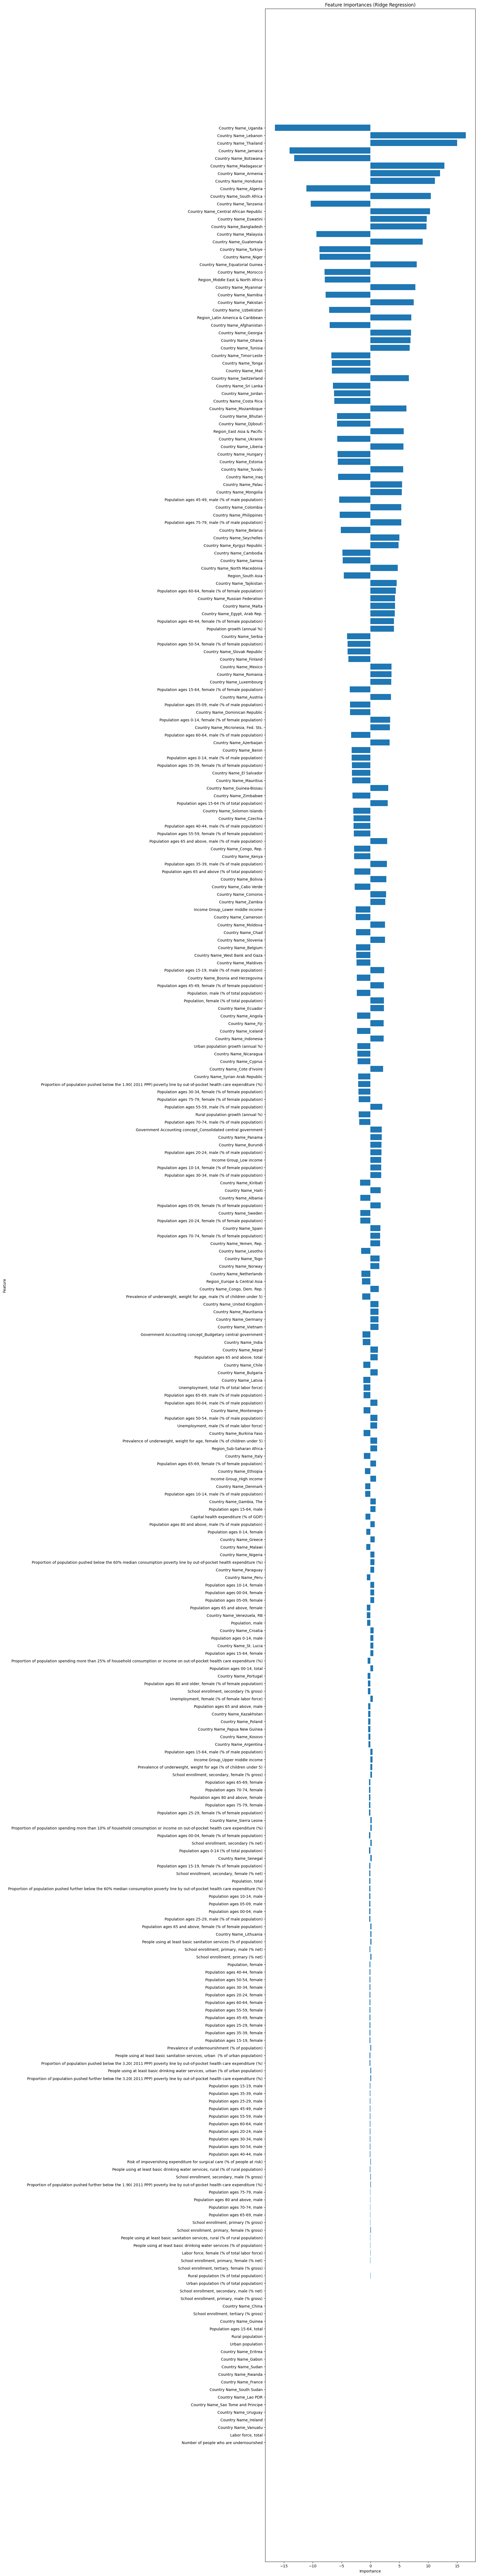

In [35]:
# Set the figure size
plt.figure(figsize=(10, len(importances_df) * 0.4))

# Create a bar chart
plt.barh(importances_df['feature'], importances_df['importance'], align='center')

# Invert the y-axis so that the most important feature appears at the top
plt.gca().invert_yaxis()

# Set labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Ridge Regression)')

# Show the plot
plt.show()

**Remove Country**

We can see based on this list, that country name is a very important variable in determining the 'Poverty headcount ratio at national poverty line (% of population)'.  However, this is expected.  Because of this, we are going to remove all Country values and recalculate the variable importance.

In [36]:
importances_non_country_df = importances_df[importances_df["feature"].str.contains("Country") == False]
print("\nFeature importances (Ridge Regression):")
print(importances_non_country_df)


Feature importances (Ridge Regression):
                                               feature    importance
297                  Region_Middle East & North Africa -7.886669e+00
296                   Region_Latin America & Caribbean  7.093772e+00
294                         Region_East Asia & Pacific  5.740666e+00
61   Population ages 45-49, male (% of male populat... -5.409162e+00
91   Population ages 75-79, male (% of male populat...  5.316901e+00
..                                                 ...           ...
37                        Population ages 15-64, total  6.988848e-03
115                                   Rural population -7.112122e-05
135                                   Urban population -7.076697e-05
2                                   Labor force, total -7.947123e-07
3              Number of people who are undernourished -1.532786e-07

[150 rows x 2 columns]


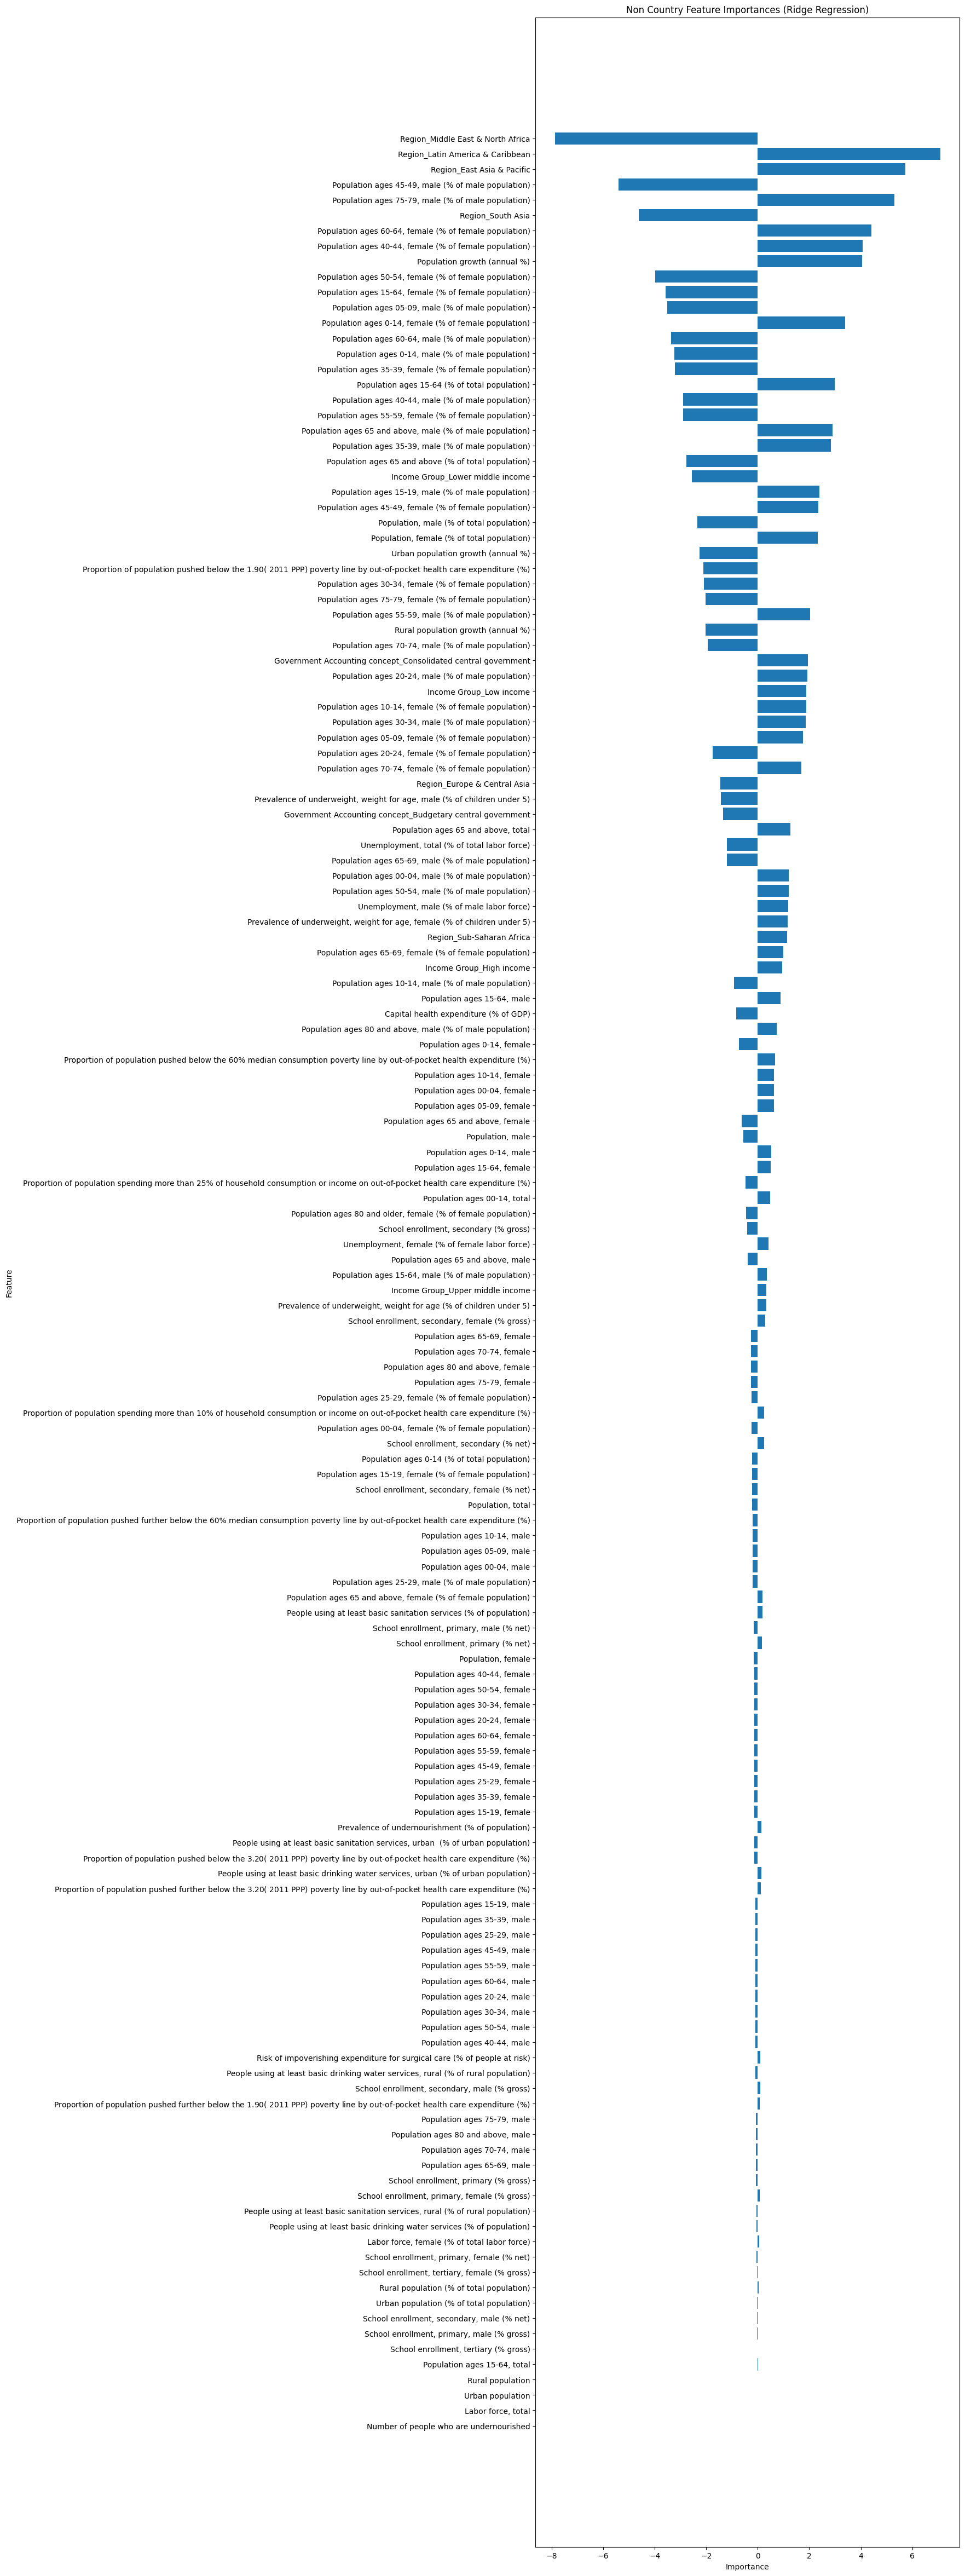

In [37]:
# Set the figure size
plt.figure(figsize=(10, len(importances_non_country_df) * 0.4))

# Create a bar chart
plt.barh(importances_non_country_df['feature'], importances_non_country_df['importance'], align='center')

# Invert the y-axis so that the most important feature appears at the top
plt.gca().invert_yaxis()

# Set labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Non Country Feature Importances (Ridge Regression)')

# Show the plot
plt.show()

**Variable Importance**

Based on this analysis, the following are key insights:


*   Region is very important, but this is related to country and something that we cannot adjust
*   Population age distribution is very importance. Countries with a high % of the population over 65% had a higher % of the population in poverty 
*   Population growth is very importance. Countries with a high population growth % had a higher % of the population in poverty 


Based on the above, the UN should target working with countries to: 

*   Develop programs for the elderly to help reduce poverty.  This can be better wellfare programs or more aid for the older population, who are likely not working as much as the younger population
*   Identify ways to support a growing population.  The government is likely not able to keep up with the growth in population, which causes an increase in poverty.  The UN should partner with countries to better support a growing population.



**Expand to Full Dataset**

For the remaining ~93% of the dataset, we will impute the NaN values using K nearest neighbot (similar to the above) and leverage Ridge Regression to predict the 'Poverty headcount ratio at national poverty line (% of population)' value.

In [38]:
poverty_completion_only_one_hot_columns = poverty_completion_only_one_hot.columns
predict_x_hnp_df_selected = hnp_df_selected
columns_to_encode = ['Country Name',  'Region', 'Income Group', 'Government Accounting concept']

predict_x_hnp_df_selected_one_hot = pd.get_dummies(predict_x_hnp_df_selected, columns=columns_to_encode)

predict_x_hnp_df_selected_one_hot = predict_x_hnp_df_selected_one_hot.iloc[:,4:]
predict_x_hnp_df_selected_one_hot = predict_x_hnp_df_selected_one_hot.dropna(axis=1, how='all')
predict_x_hnp_df_selected_one_hot = predict_x_hnp_df_selected_one_hot[poverty_completion_only_one_hot_columns.intersection(predict_x_hnp_df_selected_one_hot.columns)]
predict_x_hnp_df_selected_one_hot = predict_x_hnp_df_selected_one_hot.drop('Poverty headcount ratio at national poverty line (% of population)', axis=1)
#print(predict_x_hnp_df_selected_one_hot.shape)

predicted_knn_imputer = KNNImputer(n_neighbors=5)
predicted_knn_imputed_data = knn_imputer.fit_transform(predict_x_hnp_df_selected_one_hot)
predict_x_hnp_df_selected_knn = pd.DataFrame(predicted_knn_imputed_data, columns=predict_x_hnp_df_selected_one_hot.columns, index=predict_x_hnp_df_selected_one_hot.index)

predict_hnp_df_selected = ridge_model.predict(predict_x_hnp_df_selected_knn)

**Removing Outliers**

Looking at the data, we need to remove the outliers. We removed outliers above 60% because 97% of reponses to the 'Poverty headcount ratio at national poverty line (% of population)' question reponded with less than or equal to 60%.

In [39]:
hnp_df_selected_new_pov= hnp_df_selected 
hnp_df_selected_new_pov['Poverty % Predicted'] = predict_hnp_df_selected
conditions = [
    hnp_df_selected_new_pov['Poverty % Predicted']>= 60,
    hnp_df_selected_new_pov['Poverty % Predicted'] < 0,
    (hnp_df_selected_new_pov['Poverty % Predicted'] >= 0) & (hnp_df_selected_new_pov['Poverty % Predicted'] < 60)
]
values = [
    60,
    0,
    hnp_df_selected_new_pov['Poverty % Predicted']
]

hnp_df_selected_new_pov['Poverty % Predicted Outliers Remove'] = np.select(conditions, values, default=0)

hnp_df_selected_new_pov['Poverty % Revised'] = hnp_df_selected_new_pov.apply(lambda row: row['Poverty headcount ratio at national poverty line (% of population)'] if row['Poverty headcount ratio at national poverty line (% of population)'] > 0 else row['Poverty % Predicted Outliers Remove'], axis=1)                                                      

In [40]:
#hnp_df_selected_new_pov.to_csv('your_dataframe.csv', index=False)
#files.download('your_dataframe.csv')

**Poverty, Total**

Compute the Poverty, Total as 'Poverty % Revised'/100*'Population, total'

In [41]:
try:
    hnp_df_selected_new_pov['Poverty, Total'] = round((hnp_df_selected_new_pov['Poverty % Revised']/100)*hnp_df_selected_new_pov['Population, total'],0)
    # handle the calculation result
except Exception as e:
    hnp_df_selected_new_pov['Poverty, Total'] =0

Filter our HNPS dataset to only include rows where we have a Poverty,Total>0

In [42]:
hnp_df_poverty = hnp_df_selected_new_pov[hnp_df_selected_new_pov['Poverty, Total']>0].copy()
hnp_df_poverty['Year'] = hnp_df_poverty['Year'].astype(int)
hnp_df_poverty['Year'] = hnp_df_poverty['Year'].astype(str)
hnp_df_poverty['Poverty, Total'] = hnp_df_poverty['Poverty, Total'].astype(int)

Create a function to format our number values by adding commas.

In [43]:
format_with_commas = lambda x: "{:,}".format(x)

**Remove World and Regions**

Since the HPNS dataset has Country Names for the World and for Regions.  We'll remove the World and Regions from our dataset to create a hnp_df_poverty_countries dataset.

In [44]:
world_value= ['World']
region_values = ['IDA & IBRD total', 'Low & middle income', 'Middle income','Early-demographic dividend','Lower middle income','Upper middle income','Late-demographic dividend','East Asia & Pacific','East Asia & Pacific (excluding high income)','East Asia & Pacific (IDA & IBRD countries)','South Asia','South Asia (IDA & IBRD)','OECD members','High income','Post-demographic dividend','Europe & Central Asia','Sub-Saharan Africa','Sub-Saharan Africa (IDA & IBRD countries)','Sub-Saharan Africa (excluding high income)','Least developed countries: UN classification','Fragile and conflict affected situations','Pre-demographic dividend','Latin America & Caribbean','Latin America & the Caribbean (IDA & IBRD countries)','European Union','Heavily indebted poor countries (HIPC)','Europe & Central Asia (IDA & IBRD countries)','Latin America & Caribbean (excluding high income)','Low income','Africa Eastern and Southern','Europe & Central Asia (excluding high income)','Euro area','North America','Middle East & North Africa','Arab World','Middle East & North Africa (excluding high income)','Africa Western and Central','Middle East & North Africa (IDA & IBRD countries)','Central Europe and the Baltics','Small states', 'Other small states']
hnp_df_poverty_countries = hnp_df_poverty[~hnp_df_poverty['Country Name'].isin(region_values)]
hnp_df_poverty_countries = hnp_df_poverty_countries[~hnp_df_poverty['Country Name'].isin(world_value)]
hnp_df_poverty_world = hnp_df_poverty[hnp_df_poverty['Country Name'].isin(world_value)]
hnp_df_poverty_regions = hnp_df_poverty[hnp_df_poverty['Country Name'].isin(region_values)]
pd.set_option('display.max_rows', 60)
display(hnp_df_poverty_countries)
#hnp_df_poverty_countries.to_csv('your_dataframe.csv', index=False)
#files.download('your_dataframe.csv')


<ipython-input-44-cb146220118d>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hnp_df_poverty_countries = hnp_df_poverty_countries[~hnp_df_poverty['Country Name'].isin(world_value)]


,Year,Country Name,Country Code,Region,sub_region,continent,Income Group,Government Accounting concept,Capital health expenditure (% of GDP),"Labor force, female (% of total labor force)",...,"Unemployment, female (% of female labor force)","Unemployment, male (% of male labor force)","Unemployment, total (% of total labor force)",Urban population,Urban population (% of total population),Urban population growth (annual %),Poverty % Predicted,Poverty % Predicted Outliers Remove,Poverty % Revised,"Poverty, Total"
0,1960,Afghanistan,AFG,South Asia,Southern Asia,Asia,Low income,Consolidated central government,NaN,NaN,...,NaN,NaN,NaN,724373.0,8.401,NaN,60.753877,60.000000,60.000000,5173480
1,1961,Afghanistan,AFG,South Asia,Southern Asia,Asia,Low income,Consolidated central government,NaN,NaN,...,NaN,NaN,NaN,763336.0,8.684,5.239185,56.475902,56.475902,56.475902,4964311
2,1962,Afghanistan,AFG,South Asia,Southern Asia,Asia,Low income,Consolidated central government,NaN,NaN,...,NaN,NaN,NaN,805062.0,8.976,5.322099,57.780423,57.780423,57.780423,5182353
3,1963,Afghanistan,AFG,South Asia,Southern Asia,Asia,Low income,Consolidated central government,NaN,NaN,...,NaN,NaN,NaN,849446.0,9.276,5.366508,54.486502,54.486502,54.486502,4989582
4,1964,Afghanistan,AFG,South Asia,Southern Asia,Asia,Low income,Consolidated central government,NaN,NaN,...,NaN,NaN,NaN,896820.0,9.586,5.427080,50.579479,50.579479,50.579479,4731970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16487,2017,Zimbabwe,ZWE,Sub-Saharan Africa,Eastern Africa,Africa,Lower middle income,Budgetary central government,0.073545,52.100102,...,5.192,4.353,4.785,4755312.0,32.237,1.860765,34.421139,34.421139,30.400000,4484335
16488,2018,Zimbabwe,ZWE,Sub-Saharan Africa,Eastern Africa,Africa,Lower middle income,Budgetary central government,0.271347,52.105536,...,5.206,4.360,4.796,4848158.0,32.209,1.933653,45.667083,45.667083,45.667083,6873893
16489,2019,Zimbabwe,ZWE,Sub-Saharan Africa,Eastern Africa,Africa,Lower middle income,Budgetary central government,NaN,52.122657,...,5.248,4.393,4.833,4945719.0,32.210,1.992351,38.509645,38.509645,38.300000,5880815
16490,2020,Zimbabwe,ZWE,Sub-Saharan Africa,Eastern Africa,Africa,Lower middle income,Budgetary central government,NaN,51.841043,...,5.791,4.890,5.351,5052214.0,32.242,2.130421,38.203183,38.203183,38.203183,5986311


**Poverty, Total by Year**

With the filtered down dataset, calculate the Poverty, total by year for all of the countries combined and graph it.

In [45]:
#group poverty by year
hnp_df_poverty_countries_group = hnp_df_poverty_countries.groupby('Year')['Poverty, Total'].sum()
hnp_df_poverty_countries_group = hnp_df_poverty_countries_group.reset_index()
hnp_df_poverty_countries_group['Poverty, Total'] = hnp_df_poverty_countries_group['Poverty, Total'].apply(format_with_commas)
hnp_df_poverty_countries_group['Poverty, Total'] = hnp_df_poverty_countries_group['Poverty, Total'].str.replace(',', '').astype(int)
pd.set_option('display.max_rows', None)
display(hnp_df_poverty_countries_group)

,Year,"Poverty, Total"
0,1960,731528010
1,1961,749895030
2,1962,745401502
3,1963,766592051
4,1964,745001540
5,1965,721568767
6,1966,728804003
7,1967,724717488
8,1968,747421558
9,1969,797382441


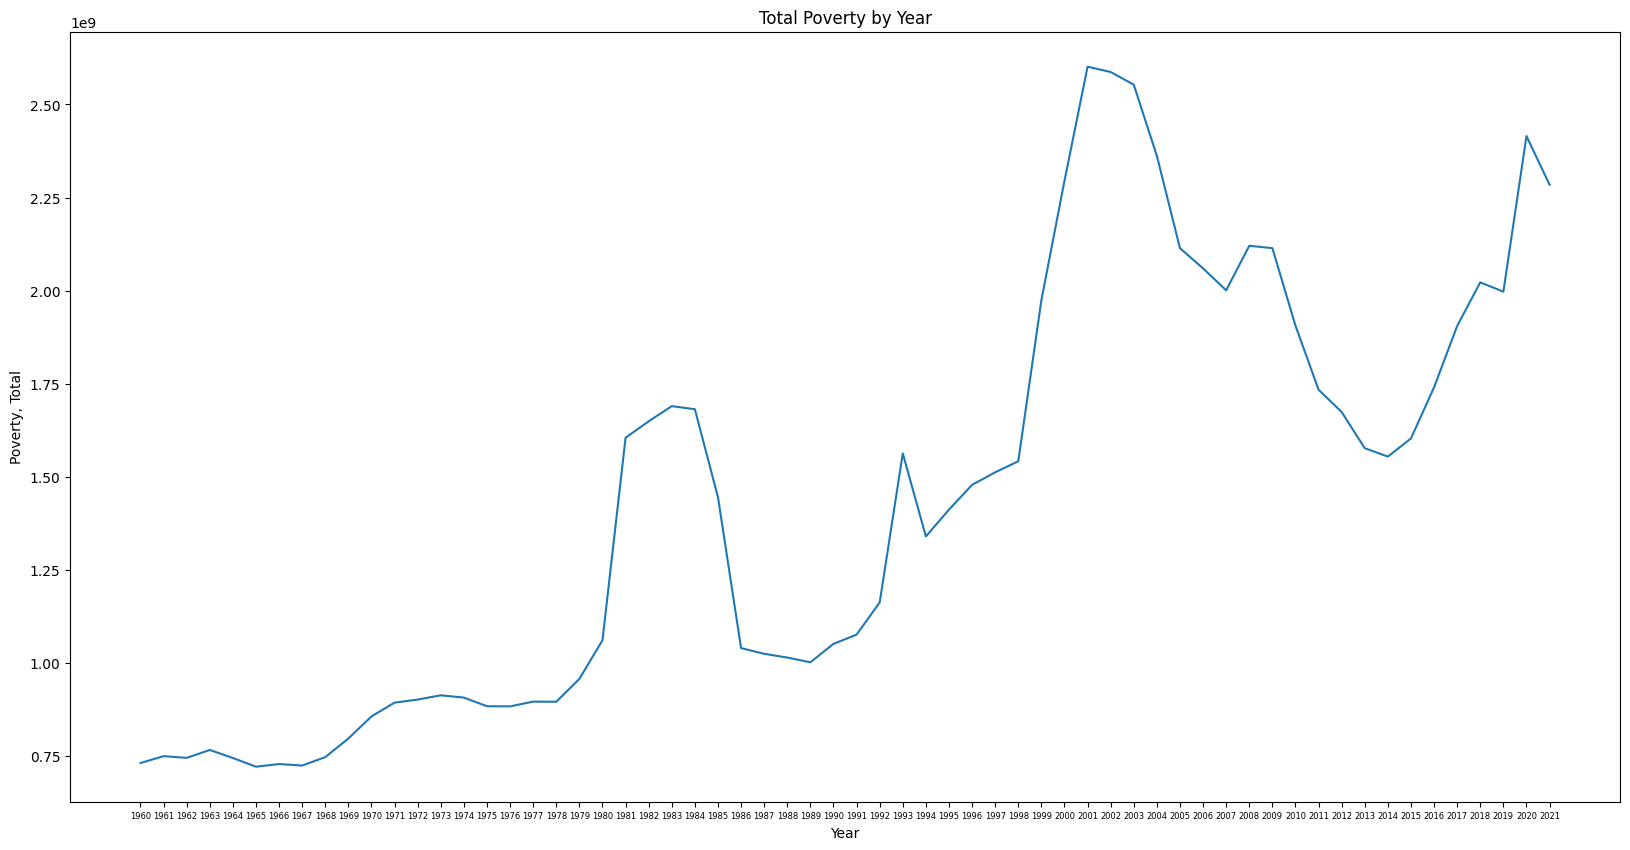

In [46]:
from matplotlib.ticker import FuncFormatter

#plot total poverty by year

def format_func(x, _):
    return '{:,.0f}'.format(x)

plt.figure(figsize=(20, 10))
# Create a line plot using the 'Year' column as the x-axis and the 'Poverty, Total' column as the y-axis
plt.plot(hnp_df_poverty_countries_group['Year'], hnp_df_poverty_countries_group['Poverty, Total'])

# Set the title and axis labels
plt.title('Total Poverty by Year')
plt.xlabel('Year')
plt.ylabel('Poverty, Total')
plt.xticks(fontsize=6)
#formatter = FuncFormatter(format_func)
#plt.gca().yaxis.set_major_formatter(formatter)

# Display the plot
plt.show()

**UN Sustainable Goal** 

With the above data, we can see that the the 2015 Poverty, Total is 1,603,158,930.  In order to achieve the 2030 goal, we need to reduce the Poverty, Total to 801,579,465 people.

**1997-2011, 2019-2021 Spikes**

As you can see above, the Povery, Total has been had a significant increase from 1997-2011, and 2019 -2021.  Let's see if there is a specific country/countries impacting this.

In [47]:
hnp_df_country = hnp_df_poverty_countries[hnp_df_poverty_countries['Year'].astype(int)>=1997]
hnp_df_country = hnp_df_country.groupby(['Country Name', 'Year']).agg({'Poverty, Total': 'sum'})
hnp_df_country = hnp_df_country.sort_values('Poverty, Total', ascending = False)
hnp_df_country['Poverty, Total'] = hnp_df_country['Poverty, Total'].apply(format_with_commas)
display(hnp_df_country.head(30))

Poverty, Total
Country Name Year               
India        2021    844,538,305
             2020    837,832,276
China        2002    768,240,000
             2001    763,110,000
             2003    743,391,157
India        2018    716,362,033
             2019    702,624,197
China        2000    628,797,210
             2004    610,192,861
India        2017    564,711,520
             2003    489,406,429
             2006    484,235,015
             2001    476,950,779
             2008    472,351,407
             2002    471,319,092
China        2009    469,782,806
India        2007    453,851,060
             2016    426,597,369
             2004    422,690,425
             2005    422,241,931
China        2005    393,723,440
             2008    366,288,068
India        2009    364,644,768
             2010    354,560,728
             2000    319,116,175
China        2006    316,346,539
India        1999    316,111,180
China        1999    289,916,937
India        2011    275,419,041
             2012    271,659,124

**China and India**

As you can see, the total China and India Poverty, Total is driving the this spike. This can be attributed to China and India having the largest populations in the world. Below is an example of the world population in 2021, showing China and India with a population over 1.4B each.

In [48]:
hnp_df_country_2021 = hnp_df_poverty_countries[hnp_df_poverty_countries['Year'].astype(int)==2021]
hnp_df_country_2021 = hnp_df_country_2021.groupby(['Country Name']).agg({'Population, total': 'sum'})
hnp_df_country_2021 = hnp_df_country_2021.sort_values('Population, total', ascending = False)
hnp_df_country_2021['Population, total'] = hnp_df_country_2021['Population, total'].apply(format_with_commas)
print(hnp_df_country_2021.head(20))

                   Population, total
Country Name                        
China                1,412,360,000.0
India                1,407,563,842.0
United States          331,893,745.0
Indonesia              273,753,191.0
Pakistan               231,402,117.0
Brazil                 214,326,223.0
Nigeria                213,401,323.0
Bangladesh             169,356,251.0
Russian Federation     143,449,286.0
Mexico                 126,705,138.0
Japan                  125,681,593.0
Ethiopia               120,283,026.0
Philippines            113,880,328.0
Egypt, Arab Rep.       109,262,178.0
Vietnam                 97,468,029.0
Congo, Dem. Rep.        95,894,118.0
Iran, Islamic Rep.      87,923,432.0
Turkiye                 84,775,404.0
Germany                 83,196,078.0
Thailand                71,601,103.0


**Region**

Since we looked at countries, let's see if we can determine which region has the largest Poverty, Total in 2021, and graph it accordingly.

In [49]:
#group poverty by year
hnp_df_poverty_regions_group = hnp_df_poverty_countries.groupby(['Year','Region'])['Poverty, Total'].sum()
hnp_df_poverty_regions_group = hnp_df_poverty_regions_group.reset_index()
hnp_df_poverty_regions_group['Poverty, Total'] = hnp_df_poverty_regions_group['Poverty, Total'].apply(format_with_commas)
hnp_df_poverty_regions_group['Poverty, Total'] = hnp_df_poverty_regions_group['Poverty, Total'].str.replace(',', '').astype(int)
pd.set_option('display.max_rows', 60)
display(hnp_df_poverty_regions_group)

,Year,Region,"Poverty, Total"
0,1960,East Asia & Pacific,166881898
1,1960,Europe & Central Asia,109225473
2,1960,Latin America & Caribbean,107927899
3,1960,Middle East & North Africa,29587073
4,1960,North America,61461213
...,...,...,...
429,2021,Latin America & Caribbean,234998369
430,2021,Middle East & North Africa,99412981
431,2021,North America,120405423
432,2021,South Asia,960704853


In [50]:
hnp_df_poverty_regions_group_2021 = hnp_df_poverty_regions_group[hnp_df_poverty_regions_group['Year']=='2021']
hnp_df_poverty_regions_group_2 = hnp_df_poverty_regions_group_2021[['Region', 'Poverty, Total']]
hnp_df_poverty_regions_group_2 = hnp_df_poverty_regions_group_2.sort_values(by='Poverty, Total', ascending=False)
print(hnp_df_poverty_regions_group_2)

                         Region  Poverty, Total
432                  South Asia       960704853
433          Sub-Saharan Africa       487432536
429   Latin America & Caribbean       234998369
427         East Asia & Pacific       230478982
428       Europe & Central Asia       149517074
431               North America       120405423
430  Middle East & North Africa        99412981


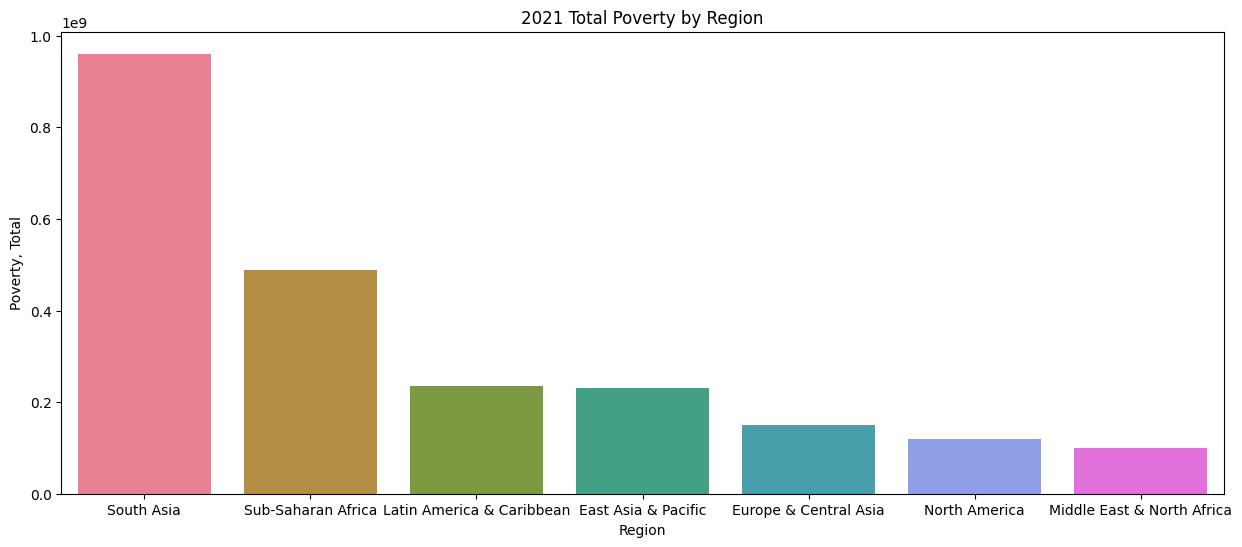

In [51]:
# Create a custom color palette
palette = sns.color_palette("husl", hnp_df_poverty_regions_group_2['Region'].nunique())

# Create a dictionary to map regions to colors
region_color_map = {region: palette[i] for i, region in enumerate(hnp_df_poverty_regions_group_2['Region'].unique())}

# Create a list of colors for the bars corresponding to the region of each row
bar_colors = hnp_df_poverty_regions_group_2['Region'].map(region_color_map).tolist()

# Create the bar plot
plt.figure(figsize=(15, 6))
barplot = sns.barplot(data=hnp_df_poverty_regions_group_2, x='Region', y='Poverty, Total', palette=bar_colors)
plt.title('2021 Total Poverty by Region')
plt.xlabel('Region')
plt.ylabel('Poverty, Total')

plt.show()

As you can see above, the South Asia region, followed by the Sub-Saharan Africa region currently has the largest amount of Poverty, Total.  The UN should target its efforts to address this region.

In [52]:
#hnp_df_poverty_countries.to_csv('your_dataframe.csv', index=False)
#files.download('your_dataframe.csv')

**Forecasting**

With a good understanding of our dataset, and the key drivers, let's try several forecasting techinques to determine if we will meet the goal by 2030.  We will use Linear Regression, Polynomial Regression, ARIMA and Exponential Smoothing.

In [53]:
total_poverty_forecasting = hnp_df_poverty_countries_group.copy()
total_poverty_forecasting['Year'] = total_poverty_forecasting['Year'].astype(int)


ARIMA with predictions from 2022 - 2032

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with a

ARIMA predictions: 62    2.297515e+09
63    2.287920e+09
64    2.287242e+09
65    2.286213e+09
66    2.285946e+09
67    2.285797e+09
68    2.285742e+09
69    2.285718e+09
70    2.285708e+09
71    2.285704e+09
Name: predicted_mean, dtype: float64


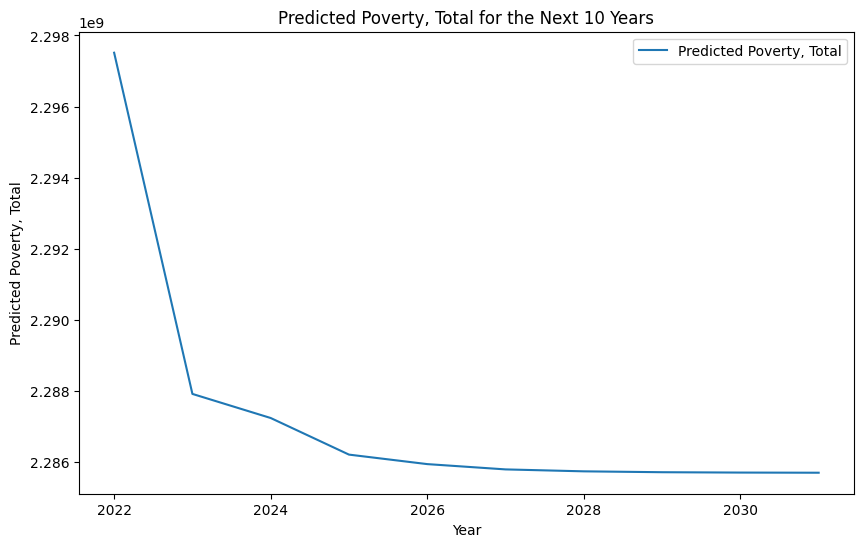

In [56]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

arima_total_poverty = total_poverty_forecasting
arima_total_poverty2 = arima_total_poverty.set_index('Year', inplace=False)

arima_model = ARIMA(arima_total_poverty2['Poverty, Total'], order=(2, 1, 0))
arima_model_fit = arima_model.fit()

# In-sample predictions (on the test set)
arima_test_predictions = arima_model_fit.predict(start=arima_total_poverty2.index[0], end=arima_total_poverty2.index[-1], typ='levels')

# Forecast the next 10 years
years_to_forecast = 10
forecast_years = np.arange(2022, 2022 + years_to_forecast)
arima_predictions = arima_model_fit.forecast(steps=10)
print("ARIMA predictions:", arima_predictions)

plt.figure(figsize=(10, 6))
plt.plot(forecast_years, arima_predictions, label='Predicted Poverty, Total')
plt.xlabel('Year')
plt.ylabel('Predicted Poverty, Total')
plt.title('Predicted Poverty, Total for the Next 10 Years')
plt.legend()
plt.show()


Exponential Smoothing with predictions from 2022 - 2032

ETS predictions: 62    2.302834e+09
63    2.321242e+09
64    2.339651e+09
65    2.358059e+09
66    2.376467e+09
67    2.394876e+09
68    2.413284e+09
69    2.431692e+09
70    2.450101e+09
71    2.468509e+09
Name: predicted_mean, dtype: float64


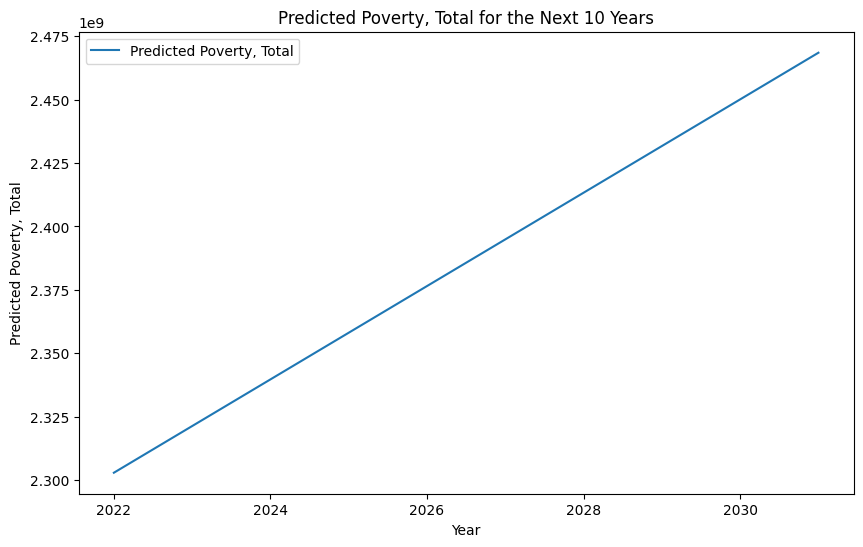

In [58]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing
from sklearn.metrics import r2_score, mean_squared_error

# Train the model
es_model = ExponentialSmoothing(total_poverty_forecasting['Poverty, Total'], trend=True, seasonal=None)
es_model_fit = es_model.fit()

# Forecast the test set
es_predictions_test = es_model_fit.forecast(steps=len(total_poverty_forecasting))

# Forecast the next 10 years
es_predictions = es_model_fit.forecast(steps=10)
print("ETS predictions:", es_predictions)

plt.figure(figsize=(10, 6))
plt.plot(forecast_years, es_predictions, label='Predicted Poverty, Total')
plt.xlabel('Year')
plt.ylabel('Predicted Poverty, Total')
plt.title('Predicted Poverty, Total for the Next 10 Years')
plt.legend()
plt.show()

LSTM with predictions from 2022 - 2032

In [59]:
LSTM_total_poverty = total_poverty_forecasting

1/1 [==============================] - 0s 24ms/step
LSTM predictions: [[2.2358262e+09]
 [2.2582405e+09]
 [2.2368284e+09]
 [2.2261993e+09]
 [2.2214185e+09]
 [2.2140989e+09]
 [2.2087483e+09]
 [2.2044902e+09]
 [2.2006326e+09]
 [2.1974582e+09]]


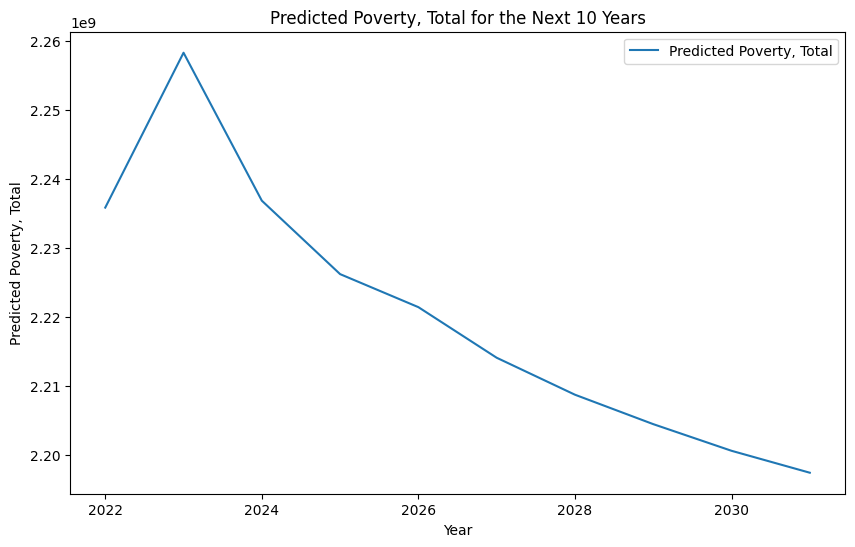

In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM



scaler = MinMaxScaler(feature_range=(0, 1))
LSTM_total_poverty['Poverty, Total'] = scaler.fit_transform(LSTM_total_poverty['Poverty, Total'].values.reshape(-1, 1))

def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back])
        y.append(dataset[i + look_back])
    return np.array(X), np.array(y)

look_back = 3
X_LSTM, y_LSTM = create_dataset(LSTM_total_poverty['Poverty, Total'].values, look_back)

X_LSTM = np.reshape(X_LSTM, (X_LSTM.shape[0], X_LSTM.shape[1], 1))

model_LSTM = Sequential()
model_LSTM.add(LSTM(4, input_shape=(look_back, 1)))
model_LSTM.add(Dense(1))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam')
model_LSTM.fit(X_LSTM, y_LSTM, epochs=100, batch_size=1, verbose=0)

years_to_forecast = 10
LSTM_predictions = []
input_data = LSTM_total_poverty['Poverty, Total'].values[-look_back:]
for _ in range(years_to_forecast):
    input_data = input_data.reshape((1, look_back, 1))
    LSTM_prediction = model_LSTM.predict(input_data)
    LSTM_predictions.append(LSTM_prediction[0][0])
    input_data = np.append(input_data[0][1:], LSTM_prediction)

LSTM_predictions = scaler.inverse_transform(np.array(LSTM_predictions).reshape(-1, 1))

forecast_years = np.arange(2022, 2022 + years_to_forecast)

print("LSTM predictions:", LSTM_predictions)
plt.figure(figsize=(10, 6))
plt.plot(forecast_years, LSTM_predictions, label='Predicted Poverty, Total') 
plt.xlabel('Year')
plt.ylabel('Predicted Poverty, Total')
plt.title('Predicted Poverty, Total for the Next 10 Years')
plt.legend()
plt.show()

Forecasting Accuracy and Prediction Summary:

In [61]:
print("\nARIMA:")
print("ARIMA predictions:", arima_predictions)

print("\nExponential Smoothing Summary:")
print("ETS predictions:", es_predictions)

print("\nLSTM Summary:")
print("LSTM predictions:", LSTM_predictions)


ARIMA:
ARIMA predictions: 62    2.297515e+09
63    2.287920e+09
64    2.287242e+09
65    2.286213e+09
66    2.285946e+09
67    2.285797e+09
68    2.285742e+09
69    2.285718e+09
70    2.285708e+09
71    2.285704e+09
Name: predicted_mean, dtype: float64

Exponential Smoothing Summary:
ETS predictions: 62    2.302834e+09
63    2.321242e+09
64    2.339651e+09
65    2.358059e+09
66    2.376467e+09
67    2.394876e+09
68    2.413284e+09
69    2.431692e+09
70    2.450101e+09
71    2.468509e+09
Name: predicted_mean, dtype: float64

LSTM Summary:
LSTM predictions: [[2.2358262e+09]
 [2.2582405e+09]
 [2.2368284e+09]
 [2.2261993e+09]
 [2.2214185e+09]
 [2.2140989e+09]
 [2.2087483e+09]
 [2.2044902e+09]
 [2.2006326e+09]
 [2.1974582e+09]]


**No Poverty Trajectory:**

As you can see above, no forecasting model is predicting that the UN will be able to achieve it's 2030 goal of cutting Poverty in half: reducing poverty to 801 million total.  The lowest amount of poverty that we achieve in 2030 is from the LSTM model, for which the 2030 prediction for total world poverty is ~2.2$B.  Poverty actually appears to be trending up.

However, based on our analysis, the UN can undertake the following initiatives:


*   Target addressing poverty in countries with high population (i.e. China, India) and/or those a population growth that is increasing significantly. The will require partnering with the government of the respective countries
*   Develop programs to address poverty for people over 65 as the countries with a high % of the population above 65 have a higher rate of poverty, meaning older populations are at more risk of being in poverty
*   Work with countries to better report there poverty ratio or 'Poverty headcount ratio at national poverty line (% of population)'.  We predicted the poverty ratio, but having more accurate data will only make this analysis more accurate.